# Processing Sequences
Using Models:
- **RNNs** and **CNNs**

In [1]:
# setup
import sys
from packaging import version
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [2]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

# Basic RNNs

Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

In [3]:
# loading the data
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


'./datasets/ridership.tgz'

In [4]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [5]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


**Task:** look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive).

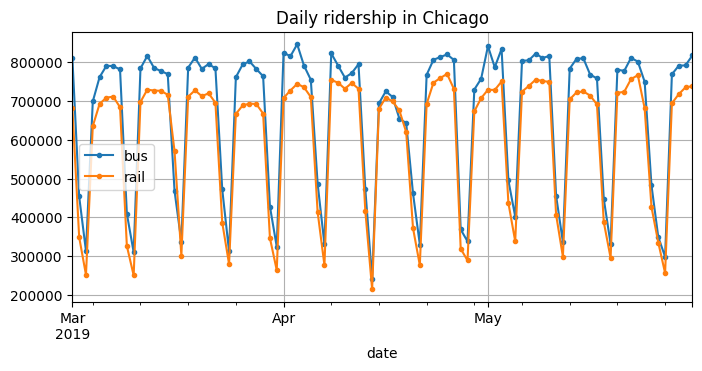

In [6]:
# Daily ridership in Chicago
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.title("Daily ridership in Chicago")
plt.show()

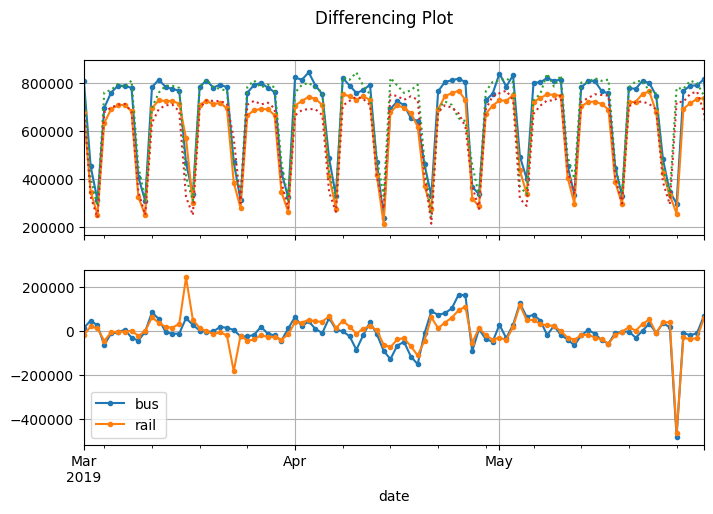

In [7]:
# Time series overlaid with 7-day lagged time series (top), and difference between t and t – 7 (bottom)
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # beautifies the plot
plt.suptitle("Differencing Plot")
plt.show()

In [8]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

**Note:** Mean absolute error (MAE), also called mean absolute deviation (MAD).

In [9]:
diff_7.abs().mean()

,0
bus,43915.608696
rail,42143.271739


Mean absolute percentage error (MAPE):

In [10]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

,0
bus,0.082938
rail,0.089948


**Task:** Yearly seasonality and the long-term trends.

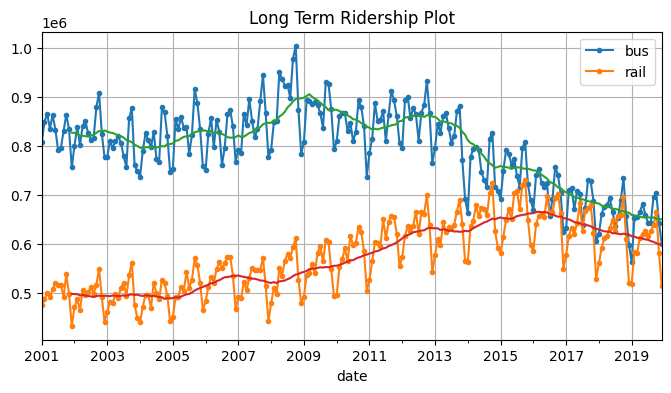

In [11]:
# Ensure the index is a DatetimeIndex
df.index = pd.to_datetime(df.index)

# Filter for numeric columns only
df_numeric = df.select_dtypes(include='number')

# Resample the numeric data to monthly frequency and compute the mean for each month
df_monthly = df_numeric.resample('M').mean()

# Define the period slice (ensure the date format matches your DataFrame)
period = slice("2001", "2019")

# Calculate the 12-month rolling average over the specified period
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

# Plot the results
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the monthly data
df_monthly[period].plot(ax=ax, marker=".")

# Plot the rolling average
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)

# Set the title and display the plot
plt.title("Long Term Ridership Plot")
plt.show()

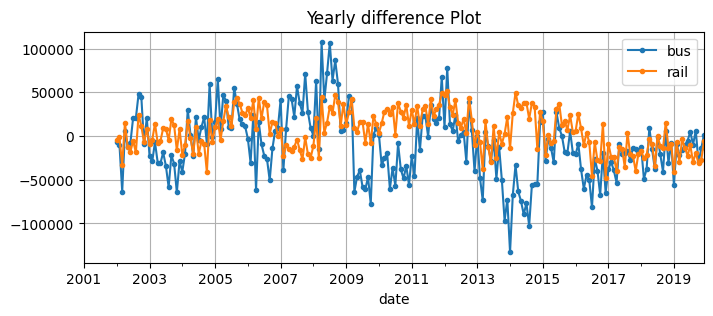

In [12]:
# The 12-month difference
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.title("Yearly difference Plot")
plt.show()

If running on Colab or Kaggle, install the statsmodels library:

In [13]:
if "google.colab" in sys.modules:
    %pip install -q -U statsmodels

In [14]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In [15]:
y_pred[0]  # ARIMA forecast

<ipython-input-15-0c8da231e770>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred[0]  # ARIMA forecast


427758.6262875742

In [16]:
df["rail"].loc["2019-06-01"]  # target value

379044

In [17]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

In [18]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

<ipython-input-18-b9d4ae04cc4b>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
<ipython-input-18-b9d4ae04cc4b>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
<ipython-input-18-b9d4ae04cc4b>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
<ipython-input-18-b9d4ae04cc4b>:10: FutureWarning: Series.__getitem__ treating keys as positions is dep

In [19]:
mae

32040.7201012105

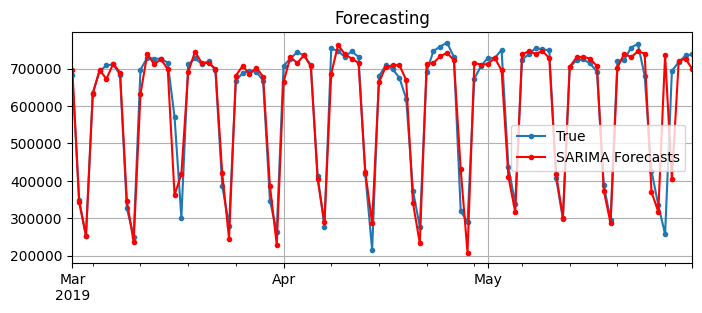

In [20]:
# displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.title("Forecasting")
plt.show()

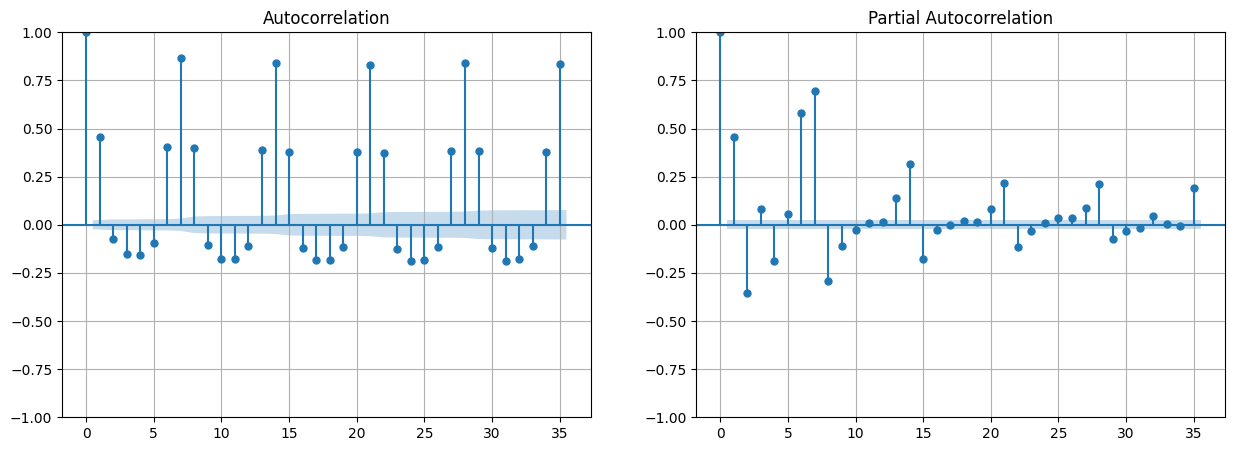

In [21]:
""" shows how to plot the Autocorrelation Function (ACF)
    and the Partial Autocorrelation Function (PACF)
"""
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

In [22]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [23]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [24]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [25]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [26]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [27]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [28]:
seq_length = 56
tf.random.set_seed(42)  # ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [29]:
# define model, set regularization and optimizer, compile and train the model
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0343 - mae: 0.2154 - val_loss: 0.0091 - val_mae: 0.1069
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0106 - mae: 0.1097 - val_loss: 0.0071 - val_mae: 0.0869
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0092 - mae: 0.0997 - val_loss: 0.0066 - val_mae: 0.0817
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0095 - mae: 0.0990 - val_loss: 0.0058 - val_mae: 0.0754
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - mae: 0.0910 - val_loss: 0.0057 - val_mae: 0.0743
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064 - mae: 0.0792 - val_loss: 0.0055 - val_mae: 0.0729
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0065 - mae: 0.0809 - val_loss: 0.0047 - val_mae: 0.0658
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068 - mae: 0.0802 - val_loss: 0.0045 - val_mae: 0.0631
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062 - ma

In [30]:
# evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - mae: 0.0386 


37432.633340358734

## Using a Simple RNN

In [31]:
tf.random.set_seed(42)  # ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
# defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [33]:
# using previous function
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.2759 - mae: 0.5950 - val_loss: 0.0878 - val_mae: 0.3804
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0802 - mae: 0.3577 - val_loss: 0.0872 - val_mae: 0.3788
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0788 - mae: 0.3539 - val_loss: 0.0853 - val_mae: 0.3740
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0779 - mae: 0.3510 - val_loss: 0.0816 - val_mae: 0.3642
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0745 - mae: 0.3417 - val_loss: 0.0726 - val_mae: 0.3391
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0624 - mae: 0.3040 - val_loss: 0.0429 - val_mae: 0.2386
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0315 - mae: 0.1830 - val_loss: 0.0139 - val_mae: 0.1384
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0149 - mae: 0.1586 - val_loss: 0.0139 - val_mae: 0.1349
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0

102780.46131134033

In [34]:
tf.random.set_seed(42)  # ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default, because we are dealing with time series
])

In [35]:
# compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.1270 - mae: 0.4043 - val_loss: 0.0116 - val_mae: 0.1379
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0113 - mae: 0.1217 - val_loss: 0.0047 - val_mae: 0.0842
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0047 - mae: 0.0719 - val_loss: 0.0021 - val_mae: 0.0428
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039 - mae: 0.0611 - val_loss: 0.0029 - val_mae: 0.0536
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0034 - mae: 0.0542 - val_loss: 0.0018 - val_mae: 0.0361
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0049 - mae: 0.0676 - val_loss: 0.0024 - val_mae: 0.0468
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0035 - mae: 0.0540 - val_loss: 0.0019 - val_mae: 0.0356
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0037 - mae: 0.0547 - val_loss: 0.0021 - val_mae: 0.0366
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - lo

29228.40043902397

## Deep RNNs

In [36]:
tf.random.set_seed(42)  # ensures reproducibility, can be deleted
# define a model
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [37]:
# compiles, fits, and evaluates the model, by using the previous defined function
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.1045 - mae: 0.3049 - val_loss: 0.0161 - val_mae: 0.1539
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0179 - mae: 0.1687 - val_loss: 0.0140 - val_mae: 0.1494
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0167 - mae: 0.1601 - val_loss: 0.0109 - val_mae: 0.1373
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0123 - mae: 0.1332 - val_loss: 0.0058 - val_mae: 0.0840
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0070 - mae: 0.0919 - val_loss: 0.0049 - val_mae: 0.0799
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0062 - mae: 0.0846 - val_loss: 0.0045 - val_mae: 0.0750
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0056 - mae: 0.0758 - val_loss: 0.0031 - val_mae: 0.0576
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0051 - mae: 0.0696 - val_loss: 0.0025 - val_mae: 0.0469
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - l

28900.87477862835

## Multivariate time series

In [38]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [39]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [40]:
import tensorflow as tf

# Set seed for reproducibility
tf.random.set_seed(42)

# Ensure that all values are numeric and of type float32
mulvar_train = mulvar_train.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
mulvar_valid = mulvar_valid.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)

# Targets for training and validation, cast to float32
train_targets = mulvar_train["rail"][seq_length:].astype(np.float32)
valid_targets = mulvar_valid["rail"][seq_length:].astype(np.float32)

# Create timeseries dataset for training
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=mulvar_train.to_numpy(),
    targets=train_targets,
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

# Create timeseries dataset for validation
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=mulvar_valid.to_numpy(),
    targets=valid_targets,
    sequence_length=seq_length,
    batch_size=32
)


In [41]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
# compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0398 - mae: 0.2241 - val_loss: 0.0080 - val_mae: 0.1184
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0043 - mae: 0.0731 - val_loss: 8.3119e-04 - val_mae: 0.0300
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - mae: 0.0404 - val_loss: 0.0010 - val_mae: 0.0340
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014 - mae: 0.0380 - val_loss: 0.0011 - val_mae: 0.0364
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013 - mae: 0.0365 - val_loss: 7.7009e-04 - val_mae: 0.0287
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - mae: 0.0359 - val_loss: 0.0011 - val_mae: 0.0376
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - mae: 0.0362 - val_loss: 8.7036e-04 - val_mae: 0.0322
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - mae: 0.0351 - val_loss: 7.1196e-04 - val_mae: 0.0261
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1

23230.016231536865

In [43]:
# build and train a multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.1177 - mae: 0.3463 - val_loss: 0.0031 - val_mae: 0.0659
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0042 - mae: 0.0718 - val_loss: 0.0016 - val_mae: 0.0445
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0020 - mae: 0.0458 - val_loss: 0.0011 - val_mae: 0.0346
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - mae: 0.0437 - val_loss: 9.0354e-04 - val_mae: 0.0314
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017 - mae: 0.0412 - val_loss: 0.0012 - val_mae: 0.0390
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - mae: 0.0404 - val_loss: 9.1113e-04 - val_mae: 0.0319
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0016 - mae: 0.0401 - val_loss: 9.6389e-04 - val_mae: 0.0331
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - mae: 0.0389 - val_loss: 8.0954e-04 - val_mae: 0.0293
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

26064.755395054817

In [44]:
# evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.62344932556

In [45]:
# evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mae(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
bus 25034
rail 27095


## Forecasting Several Steps Ahead

In [46]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


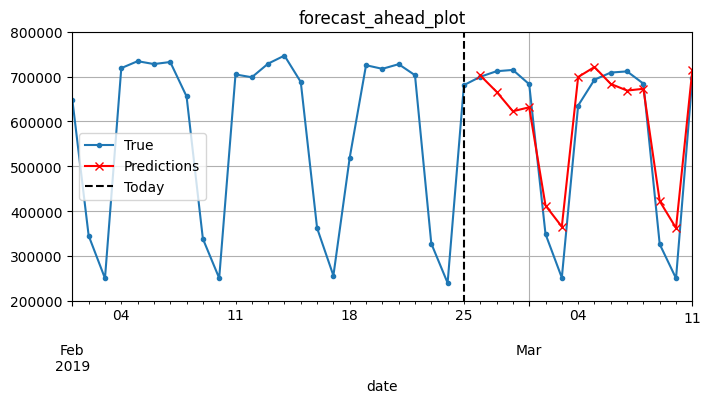

In [47]:
# orecasting 14 steps ahead, 1 step at a time
"""The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
   on 2019-03-11. That's 14 days in total.
"""
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.title("forecast_ahead_plot")
plt.show()

Now let's create an RNN that predicts all 14 next values at once:

In [48]:
tf.random.set_seed(42)  # ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [49]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [50]:
# compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.1889 - mae: 0.4977 - val_loss: 0.0309 - val_mae: 0.1926
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0245 - mae: 0.1719 - val_loss: 0.0143 - val_mae: 0.1330
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0145 - mae: 0.1346 - val_loss: 0.0106 - val_mae: 0.1132
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0115 - mae: 0.1185 - val_loss: 0.0083 - val_mae: 0.1017
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0095 - mae: 0.1072 - val_loss: 0.0068 - val_mae: 0.0926
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0084 - mae: 0.0999 - val_loss: 0.0060 - val_mae: 0.0869
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0077 - mae: 0.0947 - val_loss: 0.0053 - val_mae: 0.0826
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0070 - mae: 0.0895 - val_loss: 0.0049 - val_mae: 0.0794
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - lo

33854.70435023308

In [51]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


**Task:** Create an RNN that predicts the next 14 steps at each time step. That is, instead of just forecasting time steps 56 to 69 based on time steps 0 to 55, it will forecast time steps 1 to 14 at time step 0, then time steps 2 to 15 at time step 1, and so on, and finally it will forecast time steps 56 to 69 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

To prepare the datasets, we can use `to_windows()` twice, to get sequences of consecutive windows, like this:

In [52]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

Then we can split these elements into the desired inputs and targets:

In [53]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

Let's wrap this idea into a utility function. It will also take care of shuffling (optional) and batching:

In [54]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [55]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [56]:
tf.random.set_seed(42)  # ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
     33/Unknown 3s 31ms/step - loss: 0.1572 - mae: 0.4214

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.1548 - mae: 0.4171 - val_loss: 0.0156 - val_mae: 0.1359
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0115 - mae: 0.1161 - val_loss: 0.0076 - val_mae: 0.0866
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0072 - mae: 0.0870 - val_loss: 0.0059 - val_mae: 0.0737
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0062 - mae: 0.0789 - val_loss: 0.0056 - val_mae: 0.0709
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0055 - mae: 0.0725 - val_loss: 0.0052 - val_mae: 0.0675
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0051 - mae: 0.0684 - val_loss: 0.0047 - val_mae: 0.0618
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0049 - mae: 0.0666 - val_loss: 0.0049 - val_mae: 0.0642
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0047 - mae: 0.0642 - val_loss: 0.0047 - val_mae: 0.0623
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0045 -

46783.871948719025

In [58]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


In [59]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

      1/Unknown 0s 255ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
MAE for +1: 23,188
MAE for +2: 28,678
MAE for +3: 27,923
MAE for +4: 29,722
MAE for +5: 30,864
MAE for +6: 32,873
MAE for +7: 33,777
MAE for +8: 34,631
MAE for +9: 30,246
MAE for +10: 34,683
MAE for +11: 34,799
MAE for +12: 35,736
MAE for +13: 34,549
MAE for +14: 33,804


# Deep RNNs with Layer Norm

In [60]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [61]:
tf.random.set_seed(42) #ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Just training for 5 epochs to show that it works (we can increase this if we want):

In [62]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.1304 - mae: 0.3756 - val_loss: 0.0178 - val_mae: 0.1512
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0163 - mae: 0.1522 - val_loss: 0.0153 - val_mae: 0.1283
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0122 - mae: 0.1297 - val_loss: 0.0132 - val_mae: 0.1172
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0105 - mae: 0.1166 - val_loss: 0.0115 - val_mae: 0.1104
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0096 - mae: 0.1084 - val_loss: 0.0104 - val_mae: 0.1054
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0113 - mae: 0.1087


105394.94454860687

### Creating a Custom RNN Class

The RNN class is not magical. In fact, it's not too hard to implement own RNN class:

In [63]:
class MyRNN(tf.keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences

    def get_initial_state(self, inputs):
        try:
            return self.cell.get_initial_state(inputs)
        except AttributeError:
            # fallback to zeros if self.cell has no get_initial_state() method
            batch_size = tf.shape(inputs)[0]
            return [tf.zeros([batch_size, self.cell.state_size],
                             dtype=inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)

        if self.return_sequences:
            # stack the outputs into an array of shape
            # [time steps, batch size, dims], then transpose it to shape
            # [batch size, time steps, dims]
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

**Note:** `@tf.function` requires the `outputs` variable to be created before the `for` loop, which is why we initialize its value to a zero tensor, even though we don't use that value at all. Once the function is converted to a graph, this unused value will be pruned from the graph, so it doesn't impact performance. Similarly, `@tf.function` requires the `sequences` variable to be created before the `if` statement where it is used, even if `self.return_sequences` is `False`, so we create a `TensorArray` of size 0 in this case.

In [64]:
tf.random.set_seed(42)

custom_model = tf.keras.Sequential([
    MyRNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

<ipython-input-63-7829119c2057>:3: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Just training for 5 epochs to show that it works (we can increase this if we want):

In [65]:
fit_and_evaluate(custom_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'recurrent_kernel', 'bias', 'gamma', 'beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - loss: 0.2046 - mae: 0.5103 - val_loss: 0.0414 - val_mae: 0.2246
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0349 - mae: 0.2050 - val_loss: 0.0253 - val_mae: 0.1733
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0206 - mae: 0.1549 - val_loss: 0.0181 - val_mae: 0.1446
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0158 - mae: 0.1350 - val_loss: 0.0151 - val_mae: 0.1313
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0132 - mae: 0.1232 - val_loss: 0.0133 - val_mae: 0.1232
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0145 - mae: 0.1276


123184.94915962219

# LSTMs

In [66]:
tf.random.set_seed(42)  # ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (we can increase this if we want):

In [67]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0983 - mae: 0.3591 - val_loss: 0.0189 - val_mae: 0.1592
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0177 - mae: 0.1643 - val_loss: 0.0180 - val_mae: 0.1444
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0156 - mae: 0.1519 - val_loss: 0.0168 - val_mae: 0.1426
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0150 - mae: 0.1483 - val_loss: 0.0162 - val_mae: 0.1379
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0143 - mae: 0.1438 - val_loss: 0.0155 - val_mae: 0.1346
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0162 - mae: 0.1372


134628.43000888824

# GRUs

In [68]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [69]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1148 - mae: 0.3766 - val_loss: 0.0205 - val_mae: 0.1690
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0178 - mae: 0.1577 - val_loss: 0.0156 - val_mae: 0.1389
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0137 - mae: 0.1378 - val_loss: 0.0141 - val_mae: 0.1274
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0122 - mae: 0.1284 - val_loss: 0.0128 - val_mae: 0.1228
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0113 - mae: 0.1228 - val_loss: 0.0121 - val_mae: 0.1189
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0129 - mae: 0.1221


118924.31229352951

## Using One-Dimensional Convolutional Layers to Process Sequences

```
  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

In [70]:
tf.random.set_seed(42)  # ensures reproducibility
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Just training for 5 epochs to show that it works (we can increase this if we want):

In [71]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
     31/Unknown 4s 12ms/step - loss: 0.1138 - mae: 0.3903

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.1121 - mae: 0.3863 - val_loss: 0.0216 - val_mae: 0.1576
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0163 - mae: 0.1492 - val_loss: 0.0159 - val_mae: 0.1373
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0136 - mae: 0.1390 - val_loss: 0.0147 - val_mae: 0.1277
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0120 - mae: 0.1295 - val_loss: 0.0131 - val_mae: 0.1194
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0106 - mae: 0.1191 - val_loss: 0.0115 - val_mae: 0.1102
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0115 - mae: 0.1102


110204.93507385254

## WaveNet

```
 ⋮
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\...
   \  /  \  /  \  /  \  /  \  /  \  /  \     
     /    \      /    \      /    \          
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /...\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 111
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 112
 /14 15 16 17 18 19 20 21 22  23 24 25 26 ... 125
```

In [72]:
tf.random.set_seed(42)  # ensures reproducibility
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Just training for 5 epochs to show that it works (we can increase this if we want):

In [73]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 0.1339 - mae: 0.4497 - val_loss: 0.0233 - val_mae: 0.1626
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0178 - mae: 0.1576 - val_loss: 0.0182 - val_mae: 0.1540
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0158 - mae: 0.1563 - val_loss: 0.0179 - val_mae: 0.1502
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0152 - mae: 0.1533 - val_loss: 0.0173 - val_mae: 0.1471
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0145 - mae: 0.1495 - val_loss: 0.0162 - val_mae: 0.1403
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0162 - mae: 0.1403


140303.43294143677

### Wavenet Implementation

It uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences.

In [74]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [75]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [76]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

Just training for 5 epochs to show that it works (we can increase this if we want):

In [77]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - loss: 0.1196 - mae: 0.4097 - val_loss: 0.0233 - val_mae: 0.1624
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0153 - mae: 0.1431 - val_loss: 0.0149 - val_mae: 0.1324
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0115 - mae: 0.1249 - val_loss: 0.0125 - val_mae: 0.1199
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0096 - mae: 0.1122 - val_loss: 0.0113 - val_mae: 0.1133
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0084 - mae: 0.1026 - val_loss: 0.0100 - val_mae: 0.1062
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0100 - mae: 0.1062


106235.34768819809

There are the full fundamentals of CNNs, and RNNs: Used them to process sequences (**time series**).